In [10]:
import os
import sys
import glob
from pathlib import Path

import seaborn as sns
import matplotlib
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import brainbox
from brainbox import trainer

from block.datasets import transforms
from dblock import datasets, models, results

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
root = Path(os.path.abspath("")).parent.parent

## Build results

In [ ]:
nmnist_dataset = datasets.NMNISTDataset(os.path.join(root, "data", "N-MNIST"), train=False, dt=1, transform=transforms.List.get_nmnist_transform(300))
nmnist_root = os.path.join(root, "results/datasets/nmnist")
nmnist_query = results.DDatasetResultsBuilder(nmnist_root, nmnist_dataset, batch_size=256)

INFO:validator:Computing metric for ea2b8a656b4c424090310287d778d039...
d=10 recurrent=False method=fast_naive t_len=300 n_layers=1 detach_recurrent_spikes=True heterogeneous_beta=True
beta_requires_grad=True readout_max=False single_spike=True
kwargs={}
building d2 layer.. {'single_spike': True, 'scale': 10, 'detach_recurrent_spikes': True}
FS
building d2 layer.. {'single_spike': True, 'integrator': True}
FS
building d2 layer.. {'single_spike': True, 'integrator': True}
FS
INFO:validator:Computing metric for 5f1555df175f459c9f59794bc8359906...
d=1 recurrent=False method=fast_naive t_len=300 n_layers=1 detach_recurrent_spikes=True heterogeneous_beta=True
beta_requires_grad=True readout_max=False single_spike=True
kwargs={}
building d2 layer.. {'single_spike': True, 'scale': 10, 'detach_recurrent_spikes': True}
FS
building d2 layer.. {'single_spike': True, 'integrator': True}
FS
building d2 layer.. {'single_spike': True, 'integrator': True}
FS
INFO:validator:Computing metric for dadb6e2

In [ ]:
shd_dataset = datasets.SHDDataset(os.path.join(root, "data", "SHD"), train=False, dt=2, transform=transforms.List.get_shd_transform(500))
shd_root = os.path.join(root, "results/datasets/shd")
shd_query = results.DDatasetResultsBuilder(shd_root, shd_dataset, batch_size=256)

In [ ]:
ssc_dataset = datasets.SSCDataset(os.path.join(root, "data", "SSC"), train=False, dt=2, transform=transforms.List.get_ssc_transform(500))
ssc_root = os.path.join(root, "results/datasets/ssc")
ssc_query = results.DDatasetResultsBuilder(ssc_root, ssc_dataset, batch_size=256)

# Figure: Robustness, speedup and sparsity

In [13]:
def plot(ax, xlabel, ylabel, title, pad=17, label_size = 20):
    title_size = 20
    line_width = 3
    edge_width = 3
    errwidth = 2
    
    ax.tick_params(axis='both', which='major', pad=5, labelsize=label_size) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=title_size, pad=pad)
    
    # x-axis
    ax.spines["bottom"].set_linewidth(edge_width)
    ax.xaxis.set_tick_params(width=edge_width)
    ax.set_xlabel(xlabel, fontsize=label_size)
    
    # y-axis
    ax.spines["left"].set_linewidth(edge_width)
    ax.yaxis.set_tick_params(width=edge_width)
    ax.set_ylabel(ylabel, fontsize=label_size)
    
    ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
    
    return ax

def build_query(model_query, method, single_spike=False, readout_max=False):
    assert method in ["fast_naive", "standard"]
    query = (model_query.results_df["method"] == method)
    if method == "standard":
        query &= (model_query.results_df["single_spike"] == single_spike)
    query &= (model_query.results_df["readout_max"] == readout_max)
    query &= (model_query.results_df["beta_requires_grad"] == True)
    
    return query
    
def build_metric_dict(dataset_names, y_list, y_name):
    name_speedup_list = []
    for name, ys in zip(dataset_names, y_list):
        for y in ys:
            name_speedup_list.append({"name": name, y_name: float(y)})
        
    return name_speedup_list

palette = [sns.color_palette("light:b", as_cmap=False)[i] for i in [2, 5]]

## Plot a: Accuracy as function of d-blocks

In [14]:
def get_plot_a_data(results_df):
    q = (results_df["n_layers"] == 1) & results_df["d"].notna() & (results_df["detach_recurrent_spikes"]) & (results_df["d"].isin([1, 10, 20, 30, 40]))
    sub_results_df = results_df[q].copy()
    sub_results_df["accuracy"] *= 100
    
    return sub_results_df

In [16]:
def plot_a(results_df, title, y_label, fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    palette = [sns.color_palette("light:g", as_cmap=False)[i] for i in [2, 5]]
    sns.lineplot(data=results_df, x="d", y="accuracy", hue="recurrent", linewidth=2, marker="o", markersize=8, palette=palette, ax=ax)
    plot(ax, "Blocks $d$", y_label, title, 15)
    ax.legend().set_visible(False)
    
    return ax 

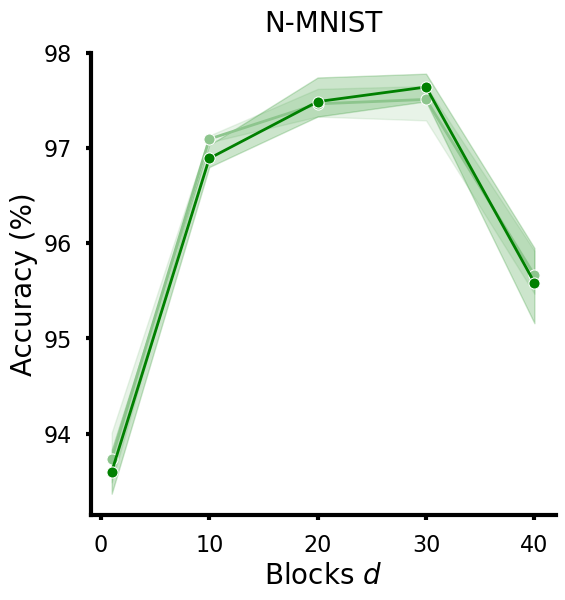

In [17]:

def plot_a_nmnist(fig, spec):
    a_nmnist_results_df = get_plot_a_data(nmnist_query.results_df)
    plot_a(a_nmnist_results_df, "N-MNIST", "Accuracy (%)", fig, spec)
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_a_nmnist(fig, fig_spec[0, 0])

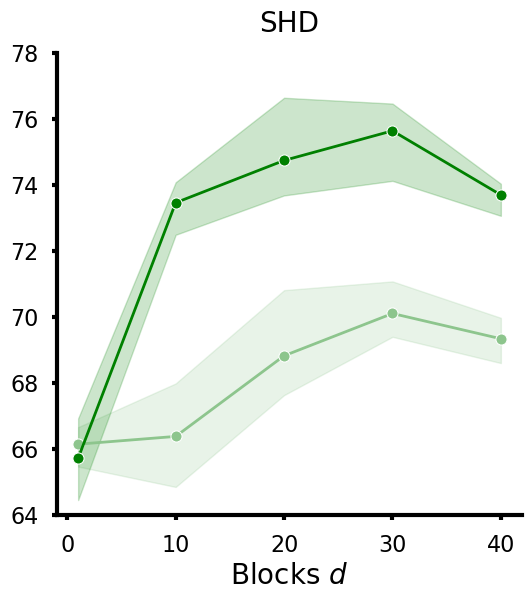

In [18]:
def plot_a_shd(fig, spec):
    a_shd_results_df = get_plot_a_data(shd_query.results_df)
    ax = plot_a(a_shd_results_df, "SHD", "", fig, spec)
    ax.set_ylim([64, 78])
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_a_shd(fig, fig_spec[0, 0])

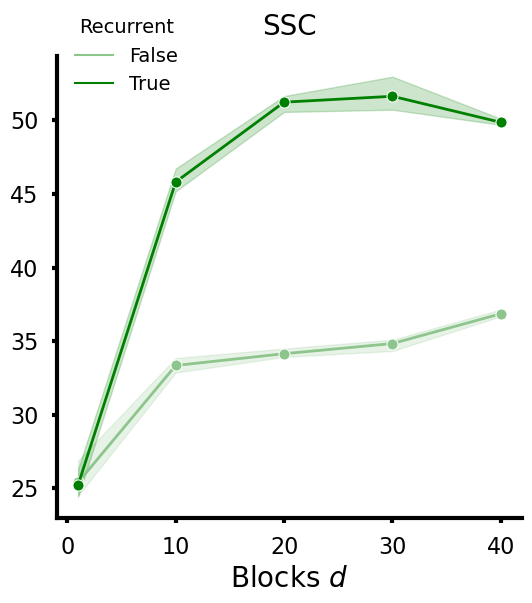

In [19]:
def plot_a_ssc(fig, spec):
    a_ssc_results_df = get_plot_a_data(ssc_query.results_df)
    ax = plot_a(a_ssc_results_df, "SSC", "", fig, spec)
    ax.legend(loc="upper left", title="Recurrent", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(0, 1.12))
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_a_ssc(fig, fig_spec[0, 0])

## Plot b: Attach/Detach spikes from recurrent connections

In [20]:
def get_plot_b_data(results_df, name):
    q = (results_df["n_layers"] == 1) & (results_df["d"] == 40) & (results_df["recurrent"])
    sub_results_df = results_df[q].copy()
    sub_results_df["name"] = name
    sub_results_df["accuracy"] *= 100
    
    return sub_results_df

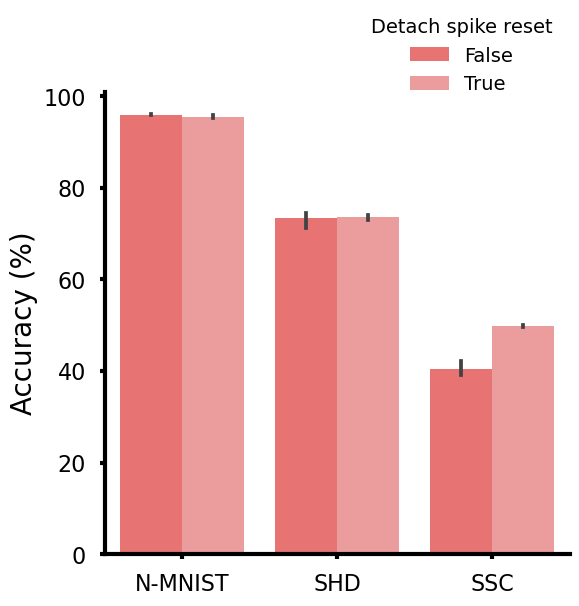

In [21]:
def plot_b(fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    
    b_nmnist_results_df = get_plot_b_data(nmnist_query.results_df, "N-MNIST")
    b_shd_results_df = get_plot_b_data(shd_query.results_df, "SHD")
    b_ssc_results_df = get_plot_b_data(ssc_query.results_df, "SSC")
    b_results_df = pd.concat([b_nmnist_results_df, b_shd_results_df, b_ssc_results_df])
    
    palette = [sns.color_palette("light:r", as_cmap=False)[i] for i in [3, 2]]
    sns.barplot(data=b_results_df, x="name", y="accuracy", hue="detach_recurrent_spikes", palette=palette, ax=ax)
    plot(ax, "", "Accuracy (%)", "", 15)
    ax.set_xticklabels(["N-MNIST", "SHD", "SSC"], rotation=0, size=16)
    #ax.legend().set_visible(False)
    ax.legend(loc="upper right", title="Detach spike reset", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(1, 1.2))
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_b(fig, fig_spec[0, 0])

## Plot c: Accuracy as function of number of layers

In [22]:
def get_plot_c_data(results_df, name):
    q = (results_df["d"] == 40) & (results_df["recurrent"]) & (results_df["detach_recurrent_spikes"])
    sub_results_df = results_df[q].copy()
    sub_results_df["name"] = name
    sub_results_df["accuracy"] *= 100
    
    return sub_results_df

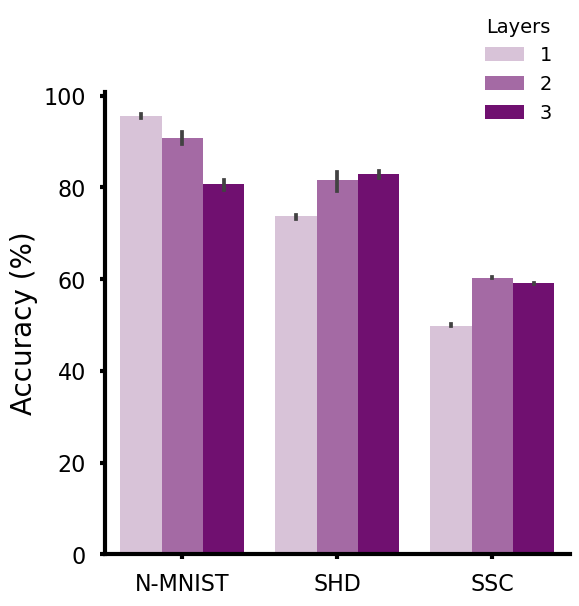

In [23]:
def plot_c(fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    
    c_nmnist_results_df = get_plot_c_data(nmnist_query.results_df, "N-MNIST")
    c_shd_results_df = get_plot_c_data(shd_query.results_df, "SHD")
    c_ssc_results_df = get_plot_c_data(ssc_query.results_df, "SSC")
    c_results_df = pd.concat([c_nmnist_results_df, c_shd_results_df, c_ssc_results_df])
    
    palette = [sns.color_palette("light:purple", as_cmap=False)[i] for i in [1, 3, 5]]
    sns.barplot(data=c_results_df, x="name", y="accuracy", hue="n_layers", palette=palette, ax=ax)
    plot(ax, "", "Accuracy (%)", "", 15)
    ax.set_xticklabels(["N-MNIST", "SHD", "SSC"], rotation=0, size=16)
    ax.legend(loc="upper right", title="Layers", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(1, 1.2))
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_c(fig, fig_spec[0, 0])

## Plot d: Speedup of models

In [32]:
def get_plot_d_data(results_df, name):
    q = (results_df["n_layers"] == 1) & (results_df["recurrent"]) & (results_df["d"].isin([np.nan, 1, 10, 20, 30, 40]))
    sub_results_df = results_df[q].copy()
    
    standard_spike_duration = float(sub_results_df[results_df["d"].notna() == False]["duration"])
    dmodel_spike_duration = sub_results_df[results_df["d"].notna()]["duration"]
    
    sub_results_df["speedup"] = standard_spike_duration / dmodel_spike_duration
    
    sub_results_df = sub_results_df[sub_results_df["d"].notna() & results_df["detach_recurrent_spikes"]].copy()
    sub_results_df["name"] = name
    
    return sub_results_df

/tmp/ipykernel_157117/2224243233.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  standard_spike_duration = float(sub_results_df[results_df["d"].notna() == False]["duration"])
/tmp/ipykernel_157117/2224243233.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dmodel_spike_duration = sub_results_df[results_df["d"].notna()]["duration"]
/tmp/ipykernel_157117/2224243233.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_results_df = sub_results_df[sub_results_df["d"].notna() & results_df["detach_recurrent_spikes"]].copy()
/tmp/ipykernel_157117/2224243233.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  standard_spike_duration = float(sub_results_df[results_df["d"].notna() == False]["duration"])
/tmp/ipykernel_157117/2224243233.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dmodel_spike_duration = sub_results_df[res

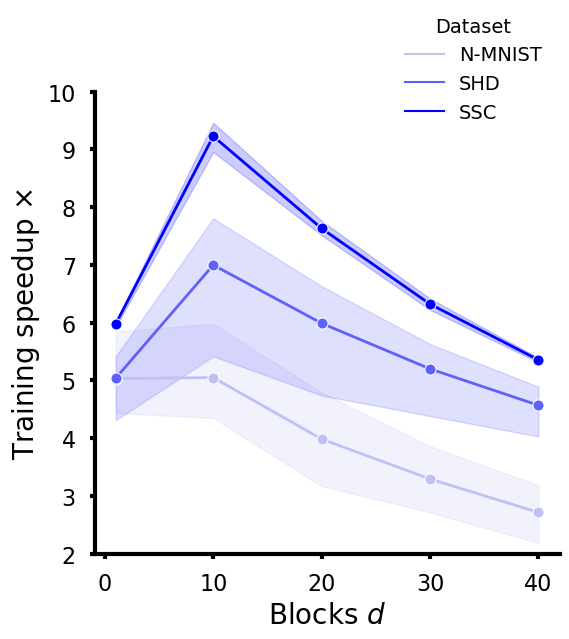

In [33]:
def plot_d(fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    
    d_nmnist_results_df = get_plot_d_data(nmnist_query.results_df, "N-MNIST")
    d_shd_results_df = get_plot_d_data(shd_query.results_df, "SHD")
    d_ssc_results_df = get_plot_d_data(ssc_query.results_df, "SSC")
    d_results_df = pd.concat([d_nmnist_results_df, d_shd_results_df, d_ssc_results_df]).reset_index()
    
    palette = [sns.color_palette("light:b", as_cmap=False)[i] for i in [1, 3, 5]]
    sns.lineplot(data=d_results_df, x="d", y="speedup", hue="name", linewidth=2, marker="o", markersize=8, palette=palette, ax=ax)
    plot(ax, "Blocks $d$", "Training speedup $\\times$", "", 15)
    ax.legend(loc="upper right", title="Dataset", fontsize=14, title_fontsize=14, frameon=False, bbox_to_anchor=(1, 1.2))
    ax.set_ylim([2, 10])
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_d(fig, fig_spec[0, 0])

## Plot f: Sparsity as function of number of d-blocks

In [36]:
def get_plot_f_data(results_df, name):
    q = (results_df["n_layers"] == 1) & (results_df["recurrent"]) & (results_df["d"].isin([np.nan, 1, 10, 20, 30, 40]))
    sub_results_df = results_df[q].copy()
    
    standard_spike_counts = float(sub_results_df[results_df["d"].notna() == False]["spike_counts"])
    dmodel_spike_counts = sub_results_df[results_df["d"].notna()]["spike_counts"]
    sub_results_df["sparsity"] = 1 - dmodel_spike_counts / standard_spike_counts
    sub_results_df["inv_sparsity"] = 1 - standard_spike_counts / dmodel_spike_counts
    
    sub_results_df = sub_results_df[sub_results_df["d"].notna() & results_df["detach_recurrent_spikes"]].copy()
    sub_results_df["name"] = name
    
    sub_results_df["sparsity"] *= 100
    #sub_results_df["sparsity"] = max(sub_results_df["sparsity"], 0)
    sub_results_df["inv_sparsity"] *= 100
    
    return sub_results_df

/tmp/ipykernel_157117/1660847402.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  standard_spike_counts = float(sub_results_df[results_df["d"].notna() == False]["spike_counts"])
/tmp/ipykernel_157117/1660847402.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dmodel_spike_counts = sub_results_df[results_df["d"].notna()]["spike_counts"]
/tmp/ipykernel_157117/1660847402.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_results_df = sub_results_df[sub_results_df["d"].notna() & results_df["detach_recurrent_spikes"]].copy()
/tmp/ipykernel_157117/1660847402.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  standard_spike_counts = float(sub_results_df[results_df["d"].notna() == False]["spike_counts"])
/tmp/ipykernel_157117/1660847402.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dmodel_spike_counts = sub_results_df

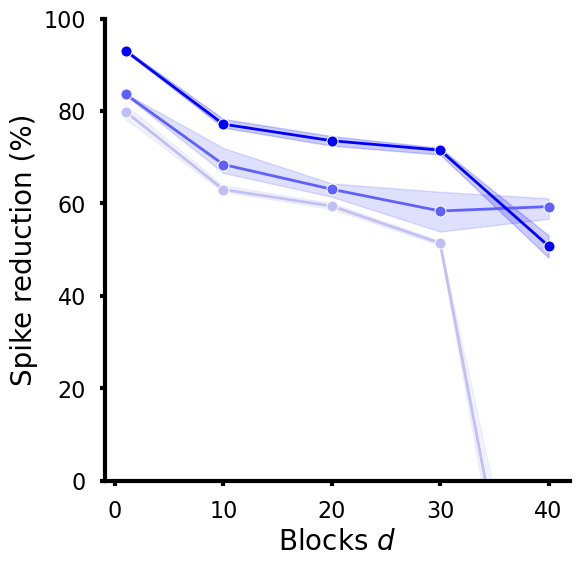

In [37]:
# TODO: Change palette
# TODO: Change accuracy

def plot_f(fig, spec):
    ax = plt.Subplot(fig, spec)
    fig.add_subplot(ax)
    
    f_nmnist_results_df = get_plot_f_data(nmnist_query.results_df, "N-MNIST")
    f_shd_results_df = get_plot_f_data(shd_query.results_df, "SHD")
    f_ssc_results_df = get_plot_f_data(ssc_query.results_df, "SSC")
    f_results_df = pd.concat([f_nmnist_results_df, f_shd_results_df, f_ssc_results_df]).reset_index()
    
    palette = [sns.color_palette("light:b", as_cmap=False)[i] for i in [1, 3, 5]]
    sns.lineplot(data=f_results_df, x="d", y="sparsity", hue="name", linewidth=2, marker="o", markersize=8, palette=palette, ax=ax)
    plot(ax, "Blocks $d$", "Spike reduction (%)", "", 15)
    ax.legend().set_visible(False)
    ax.set_ylim([0, 100])
    
fig = plt.figure(figsize=(6, 6))
fig_spec = gridspec.GridSpec(1, 1, hspace=0.1, wspace=0.1)
plot_f(fig, fig_spec[0, 0])

## Omnipotent plot

In [40]:
def plot_letter(letter, fig_spec, scale=1):
    shift = 0.1#0.2
    fontsize = 25
    ax = plt.Subplot(fig, fig_spec)
    ax.text(-shift/scale, 1.25, letter, horizontalalignment="right", verticalalignment="top", transform=ax.transData, fontweight="bold", fontsize=fontsize)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.patch.set_alpha(0)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    fig.add_subplot(ax)

/tmp/ipykernel_157117/2224243233.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  standard_spike_duration = float(sub_results_df[results_df["d"].notna() == False]["duration"])
/tmp/ipykernel_157117/2224243233.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dmodel_spike_duration = sub_results_df[results_df["d"].notna()]["duration"]
/tmp/ipykernel_157117/2224243233.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sub_results_df = sub_results_df[sub_results_df["d"].notna() & results_df["detach_recurrent_spikes"]].copy()
/tmp/ipykernel_157117/2224243233.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  standard_spike_duration = float(sub_results_df[results_df["d"].notna() == False]["duration"])
/tmp/ipykernel_157117/2224243233.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dmodel_spike_duration = sub_results_df[res

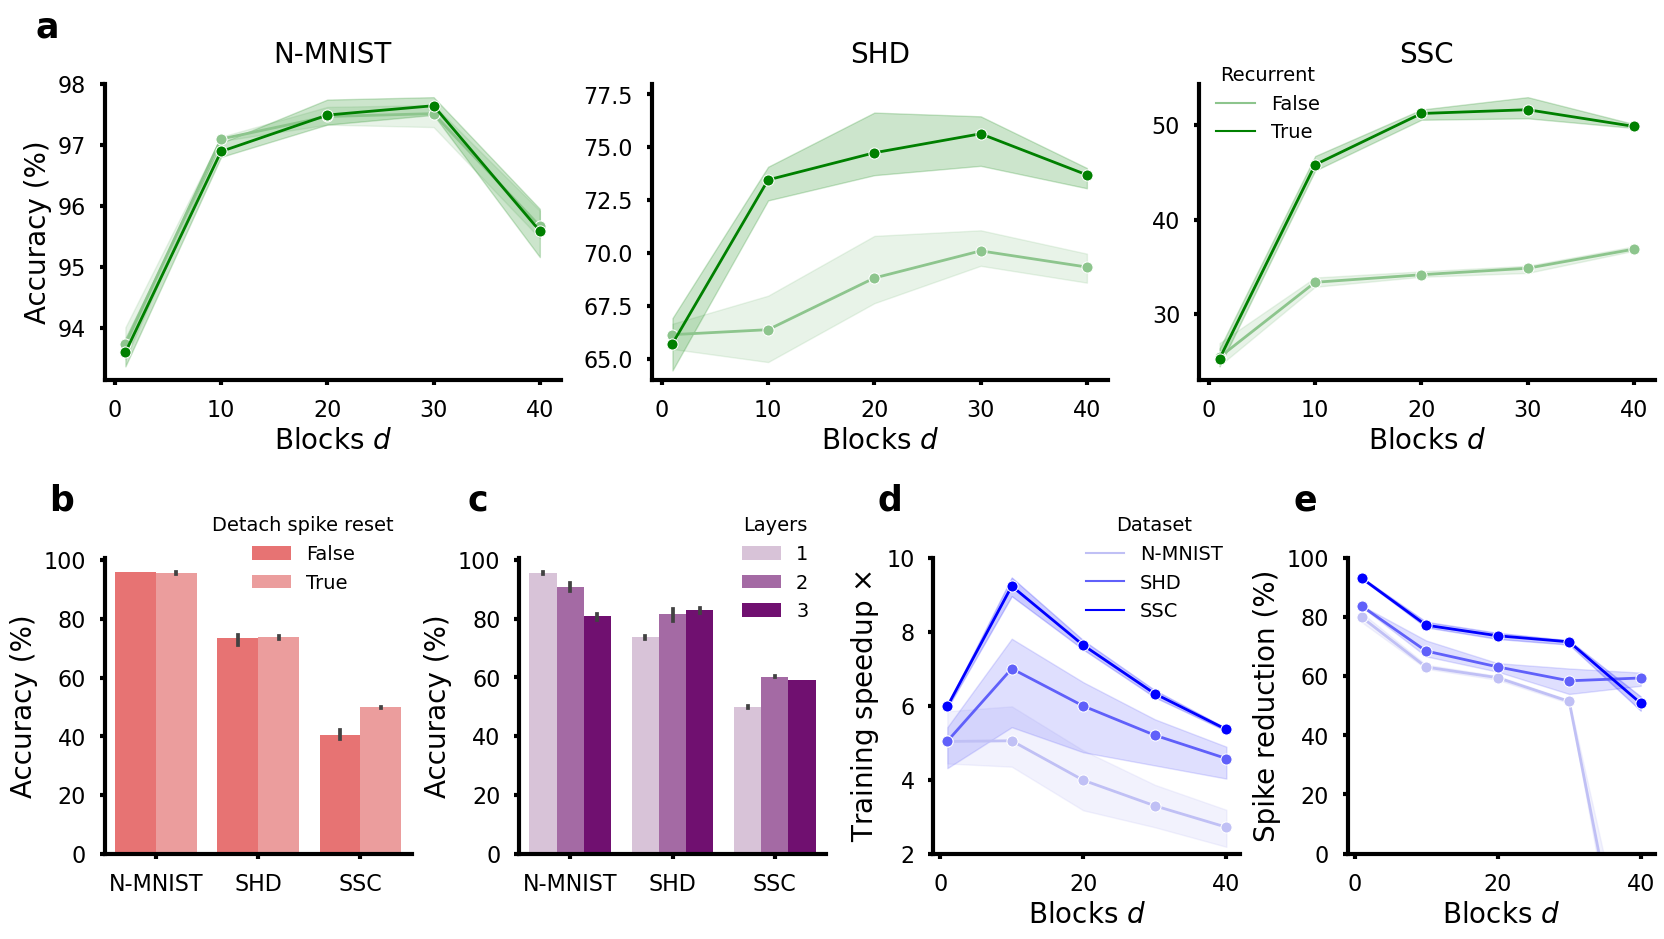

In [43]:
space = 0.65
fig = plt.figure(figsize=(20, 10))
fig_spec = gridspec.GridSpec(2, 1, hspace=0.6)
top_spec = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=fig_spec[0], wspace=0.2, hspace=0.3)
bottom_spec = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=fig_spec[1], wspace=0.35, hspace=0.3)

plot_a_nmnist(fig, top_spec[0, 0])
plot_a_shd(fig, top_spec[0, 1])
plot_a_ssc(fig, top_spec[0, 2])

plot_b(fig, bottom_spec[0, 0])
plot_c(fig, bottom_spec[0, 1])
plot_d(fig, bottom_spec[0, 2])
plot_f(fig, bottom_spec[0, 3])

plot_letter("a", top_spec[0, 0])
plot_letter("b", bottom_spec[0, 0])
plot_letter("c", bottom_spec[0, 1])
plot_letter("d", bottom_spec[0, 2])
plot_letter("e", bottom_spec[0, 3])

plt.savefig(f"{root}/figures/figure4.pdf", dpi=300, bbox_inches="tight")